

<p style="font-family: consolas; font-size: 16px;"><code>Goal</code>: The goal is to be able to classify different sounds in an urban environment - and find those gunshots to detect crime!
</p>

* [0. Import all dependencies](#0)
* [1. Import and Overview of the Training Data](#1)
* [2. Creating our Features!](#2)
* [3. Modelling](#3)
* [4. Predictions](#4)

In [2]:
!pip install resampy
import librosa 
import pandas as pd 
import numpy as np
import random 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import Audio

In [3]:
audiofiles = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
audiofiles.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
audiofiles['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [5]:
idx = list(np.where(audiofiles['class']=='gun_shot')[0])[0]

arr = np.array(audiofiles['slice_file_name'])
fold = np.array(audiofiles['fold'])
cla = np.array(audiofiles['class'])

original_audio, sample_rate = librosa.load(r'/kaggle/input/urbansound8k/fold' + str(fold[idx]) + '/' + str(arr[idx]))

Audio(data= original_audio, rate = sample_rate)

Text(0.5, 23.52222222222222, 'Time [secs]')

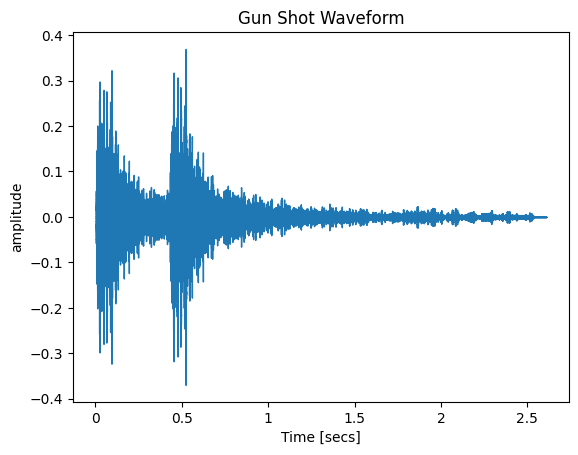

In [6]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(original_audio,sr=sample_rate,ax=ax)
ax.set(title='Gun Shot Waveform')
ax.set_ylabel('amplitude')
ax.set_xlabel('Time [secs]')

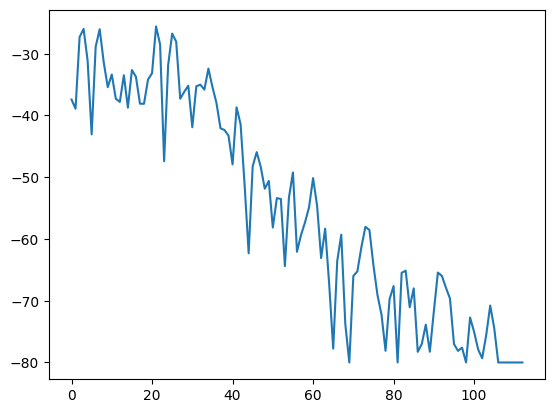

In [7]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio)),ref = np.max)
D.shape

plt.plot(D[100])

Text(0.5, 1.0, 'gun_shot')

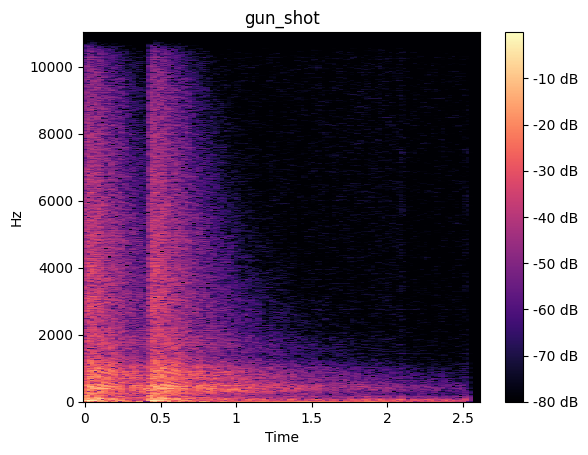

In [8]:
librosa.display.specshow(D,y_axis='linear',x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(cla[idx])

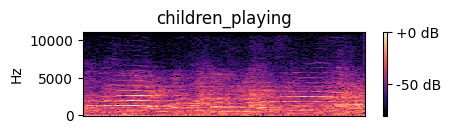

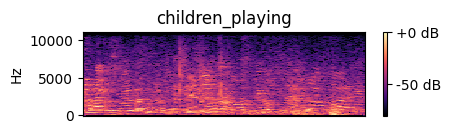

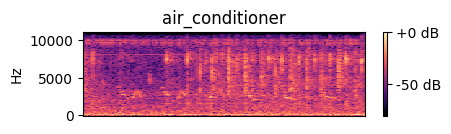

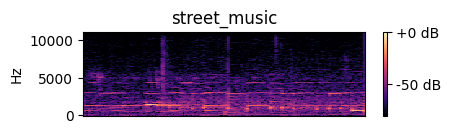

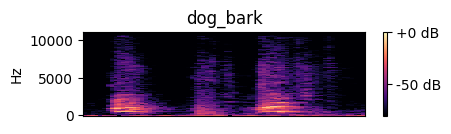

In [9]:
rng = np.random.default_rng()
sample = rng.integers(0,audiofiles.shape[0], size = 5)

for i in sample: 
    path = r'/kaggle/input/urbansound8k/fold' + str(fold[i]) + '/' + str(arr[i])
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize =(10,5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)),ref=np.max)
    plt.subplot(4,2,1)
    librosa.display.specshow(D,y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

(128, 113)
gun_shot


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

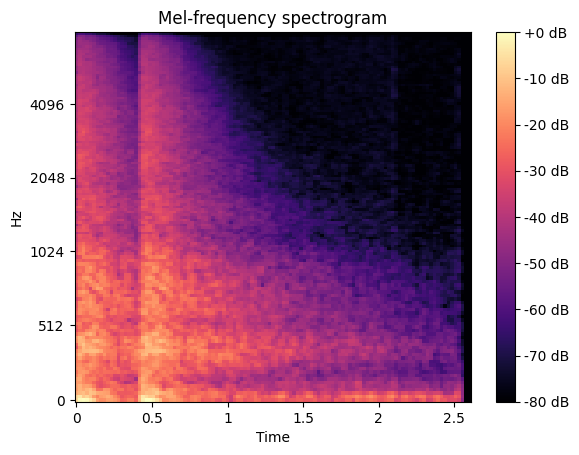

In [10]:
path = r'/kaggle/input/urbansound8k/fold' + str(fold[idx]) + '/' + str(arr[idx])
data, sampling_rate = librosa.load(path)
melspec = librosa.feature.melspectrogram(y=data,sr=sampling_rate)
print(melspec.shape)
print(cla[idx])

Audio(data=data,rate = sampling_rate)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [11]:
feature = []
label = []

for i in range(len(audiofiles)):
    filename = r'/kaggle/input/urbansound8k/fold' + str(audiofiles['fold'][i]) + '/' + str(audiofiles['slice_file_name'][i])
    X, sample_rate = librosa.load(filename, res_type='kaiser_fast')
    mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0)
    feature.append(mels)
    label.append(audiofiles['classID'][i])


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [13]:
classids = audiofiles['classID'].unique()
classes = audiofiles['class'].unique()

In [15]:
temp = np.array([feature,label],dtype='object')
data = temp.transpose()


In [16]:
X_ = data[:,0]
Y = data[:,1]

print(X_.shape,Y.shape)

(8732,) (8732,)


In [17]:
X = np.empty([8732,128])

for i in range(8732):
    X[i] = (X_[i])

In [18]:
Y = to_categorical(Y)

In [19]:
print(X.shape)
(Y.shape)

(8732, 128)


(8732, 10)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=123,test_size = 0.2)
print('Number of Train Samples',X_train.shape[0])
print('Number of test samples',X_test.shape[0])

Number of Train Samples 6985
Number of test samples 1747


In [21]:
model = Sequential(
        [
            Dense(1000,activation='relu',input_shape=(128,)),
            Dense(750,activation='relu'),
            Dense(500,activation='relu'),
            Dense(250,activation='relu'),
            Dense(100,activation='relu'),
            Dense(50,activation='relu'),
            Dense(10,activation='softmax'),
            
        ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              129000    
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 250)               125250    
                                                                 
 dense_4 (Dense)             (None, 100)               25100     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                5

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=90,batch_size=50,validation_data=[X_test,Y_test])

Epoch 1/90
140/140 [==============================] - 3s 15ms/step - loss: 2.1812 - accuracy: 0.3072 - val_loss: 1.9114 - val_accuracy: 0.3555
Epoch 2/90
140/140 [==============================] - 2s 13ms/step - loss: 1.7834 - accuracy: 0.4178 - val_loss: 1.6941 - val_accuracy: 0.4688
Epoch 3/90
140/140 [==============================] - 2s 13ms/step - loss: 1.4831 - accuracy: 0.5283 - val_loss: 1.4796 - val_accuracy: 0.5495
Epoch 4/90
140/140 [==============================] - 2s 13ms/step - loss: 1.3281 - accuracy: 0.5704 - val_loss: 1.4947 - val_accuracy: 0.5638
Epoch 5/90
140/140 [==============================] - 2s 13ms/step - loss: 1.1917 - accuracy: 0.6102 - val_loss: 1.3145 - val_accuracy: 0.6005
Epoch 6/90
140/140 [==============================] - 2s 14ms/step - loss: 1.0695 - accuracy: 0.6626 - val_loss: 1.2230 - val_accuracy: 0.6474
Epoch 7/90
140/140 [==============================] - 2s 13ms/step - loss: 0.8824 - accuracy: 0.7233 - val_loss: 1.0188 - val_accuracy: 0.6938

In [23]:
classes = audiofiles.groupby('classID')['class'].unique()
classes

classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object

In [24]:
def prediction_parser(filename,model):
    feature = []
    label = []
    # Here kaiser_fast is a technique used for faster extraction
    audiodata, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    # We extract mfcc feature from data
    mels = np.mean(librosa.feature.melspectrogram(y=audiodata, sr=sample_rate).T,axis=0)        
    feature.append(mels)
    label.append(audiofiles["class"][audiofiles['slice_file_name']==filename.split('/',5)[5]].values[0])
    temp_preds = np.array([feature,label],dtype=object)
    data_preds = temp_preds.transpose()
    X_ = data_preds[:, 0]
    X = np.empty([1, 128])
    X[0] = (X_[0])
    Audio(data = original_audio, rate = sample_rate)
    classid = np.argmax(model.predict(X))
    print('Class predicted :',classes[classid][0],'\n\n','actual',label)
    return (Audio(data = audiodata, rate = sample_rate))

In [25]:
prediction_parser('/kaggle/input/urbansound8k/fold1/102305-6-0-0.wav',model)

1/1 [==============================] - 0s 116ms/step
Class predicted : gun_shot 

 actual ['gun_shot']


In [28]:
prediction_parser('/kaggle/input/urbansound8k/fold6/101281-3-0-0.wav',model)

1/1 [==============================] - 0s 24ms/step
Class predicted : dog_bark 

 actual ['dog_bark']


In [29]:
prediction_parser('/kaggle/input/urbansound8k/fold5/100263-2-0-117.wav',model)

1/1 [==============================] - 0s 22ms/step
Class predicted : children_playing 

 actual ['children_playing']


In [30]:
prediction_parser('/kaggle/input/urbansound8k/fold3/103199-4-0-6.wav',model)

1/1 [==============================] - 0s 23ms/step
Class predicted : drilling 

 actual ['drilling']


In [31]:
prediction_parser('/kaggle/input/urbansound8k/fold1/103258-5-0-19.wav',model)

1/1 [==============================] - 0s 22ms/step
Class predicted : engine_idling 

 actual ['engine_idling']


In [32]:
prediction_parser('/kaggle/input/urbansound8k/fold8/107190-3-0-0.wav',model)

1/1 [==============================] - 0s 32ms/step
Class predicted : dog_bark 

 actual ['dog_bark']


In [33]:
prediction_parser('/kaggle/input/urbansound8k/fold7/102853-8-0-2.wav',model)

1/1 [==============================] - 0s 33ms/step
Class predicted : siren 

 actual ['siren']


In [26]:
audiofiles['slice_file_name'][idx]
# audiofiles['fold'][idx]

'102305-6-0-0.wav'